# Vaje 8: Nevronske mreže 2

## Naloga 1: Samokodirniki

Naloga samokodirnikov je podatke "stisnit" oz vpet (to boste kasneje delali na predavanjih) v prostor nižje dimenzije (imenovan tudi latentni prostor). Podatke tako preslikajo v latentni prostor in nazaj v originalen prostor. Pri tem je cilj, da se originalni podatki in rekonstruirani podatki čim bolj skladajo (oz. imamo nizko rekonstrukcijsko napako).

Poglejmo si primer samokodirnika na primeru od zadnjič; slikah ročno napisanih števk.

In [1]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import torchvision.transforms as transform
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
train_set = MNIST('../Podatki/', train=True, download=True, 
                  transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

# Naložimo testno množico, slike pretvorimo v tenzorje in jih standardiziramo
test_set = MNIST('../Podatki/', train=False, download=True, 
                 transform=transform.Compose([transform.ToTensor(), transform.Normalize((0.1307,), (0.3081,))]))

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True)

1.a: Dopolni nevronski mreži `Encoder` (kodirnik) in `Decoder` (dekodirnik). Kodirnik bo sliko zakodiral v latentni prostor, Dekodirnik pa bo sliko dekodiral iz latentnega prostora nazaj v originalen prostor (prostor slik).

Kodirnik naj vsebuje tri konvolucijske sloje (s 8, 16 in 32 izhodnih kanalov, konvolucijskim jedrom 3, stride 2 in prva dva padding 1, zadnji 0) in dva polno povezana sloja (prvi z vhodno dimenzijo 3*3*32 in izhodno dimenzijo 128 in drugi z izhodno dimenzijo `latent_dimension`). Kjer je smiselno dodaj aktivacijsko funkcijo ReLu, takoj za drugim konvolucijskim slojem BatchNorm2d sloj (s parametrom 16) in pred prvim polno-povezanim slojem ne pozabim slike spremeniti v vektor (uporabi parameter start_dim=1)

Dekodirnik naj vsebuje iste sloje, a v obratni smeri. Tu namesto Conv2D uporabi ConvTranspose2d in poleg parametra padding nastavi še parameter output_padding (na isto vrednost). Za drugim polno-povezanim slojem vektor pretvori v slike z nn.Unflatten (dim=1, unflatten_size=(32, 3, 3)).

In [3]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()
        
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(num_features=16),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(start_dim=1),
            nn.Linear(in_features=288, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=latent_dimension)
            
        )
        
    def forward(self, x):
        x = self.encoder_cnn(x)
        return x
    

class Decoder(nn.Module):
    def __init__(self, latent_dimension):
        super().__init__()
        self.decoder_cnn = nn.Sequential(
            nn.Linear(in_features=latent_dimension, out_features=128),
            nn.ReLU(),
            nn.Linear(in_features=128, out_features=288),
            nn.Unflatten (dim=1, unflattened_size=(32, 3, 3)), # vektor pretvorim v slike
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=0, output_padding=0),
            nn.ReLU(),
            nn.BatchNorm2d(16),  # simetrično z BatchNorm v encoderju (po drugem conv)
            nn.ConvTranspose2d(in_channels=16, out_channels=8,  kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8,  out_channels=1,  kernel_size=3, stride=2, padding=1, output_padding=1),
            
        )
        
    def forward(self, x):
        x = self.decoder_cnn(x)
        return torch.sigmoid(x) # dodamo sigmoid, če želimo output v [0,1] (priporočeno za normalizirane slike)

In [4]:
# preverim če dimenzije štimajo
enc = Encoder(latent_dimension=32)
dec = Decoder(latent_dimension=32)
x = torch.randn(4,1,28,28)
z = enc(x)
recon = dec(z)
print(z.shape)      # (4, 32)
print(recon.shape) 

torch.Size([4, 32])
torch.Size([4, 1, 28, 28])


Modela natreniraj. To lahko traja nekaj minut.

In [5]:
loss_fn = torch.nn.MSELoss()

lr= 0.001

torch.manual_seed(0)

encoder = Encoder(latent_dimension=5)
decoder = Decoder(latent_dimension=5)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

num_epochs = 20
for epoch in range(num_epochs):
    encoder.train()
    decoder.train()
    train_loss = []
    for image_batch, _ in train_loader:
        encoded_data = encoder(image_batch)
        decoded_data = decoder(encoded_data)
        loss = loss_fn(decoded_data, image_batch)
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss.append(loss.detach().cpu().numpy())
    print(f"Epoch {epoch}, loss: {np.mean(train_loss)}")

Epoch 0, loss: 0.7406734824180603
Epoch 1, loss: 0.5826119184494019
Epoch 2, loss: 0.5712225437164307
Epoch 3, loss: 0.5656022429466248
Epoch 4, loss: 0.5618677735328674
Epoch 5, loss: 0.5593238472938538
Epoch 6, loss: 0.5572948455810547
Epoch 7, loss: 0.555657148361206
Epoch 8, loss: 0.5542439818382263
Epoch 9, loss: 0.553210437297821
Epoch 10, loss: 0.552260160446167
Epoch 11, loss: 0.5513859987258911
Epoch 12, loss: 0.55076003074646
Epoch 13, loss: 0.5500149130821228
Epoch 14, loss: 0.5493559837341309
Epoch 15, loss: 0.5487445592880249
Epoch 16, loss: 0.5483817458152771
Epoch 17, loss: 0.5480222105979919
Epoch 18, loss: 0.5476175546646118
Epoch 19, loss: 0.54729163646698


1.b: Poglejmo si kako dobro model slike rekonstruira. V spodnji kodi dopolni vrstico, s katero dobimo rekonstruirano sliko.

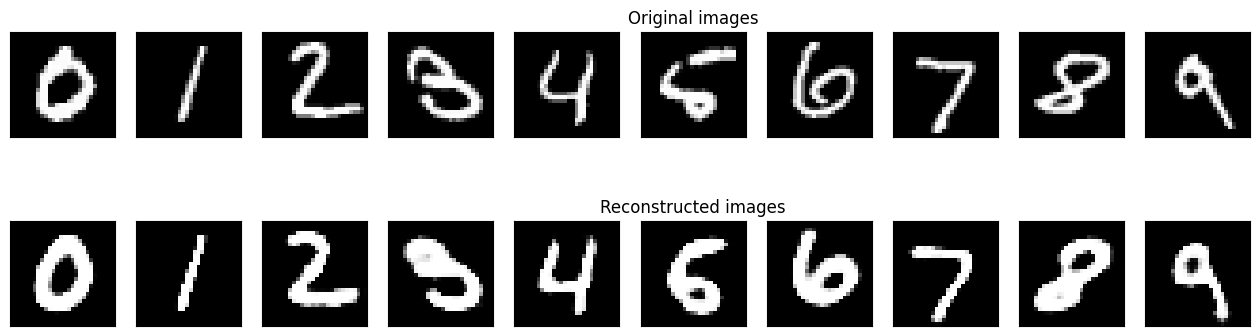

In [6]:
plt.figure(figsize=(16,4.5))
targets = test_set.targets.numpy() # oznake vseh slih v testnem setu
t_idx = {i: np.where(targets==i)[0][0] for i in range(10)} # prvi indeks vsake številke od 0 do 9

for i in range(10):
    ax = plt.subplot(2, 10, i+1)
    img = test_set[t_idx[i]][0].unsqueeze(0) #slika v obliki tensorja za dano št od 0 do 9
    # unsqueeze(0) doda dimenzijo batcha, da ima img obliko [1, 1, 28, 28]
    encoder.eval() #Preklopi mreži v eval način
    decoder.eval()
    plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')  #izriše prvotno sliko
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == 5:
        ax.set_title('Original images')
    ax = plt.subplot(2, 10, i + 11) 
    with torch.no_grad(): # Brez sledenja gradientom (no_grad)
        enc = encoder(img) # enc je latentni vektor, ki ga ustvari encoder
        rec_img  = decoder(enc)
    plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)  
    if i == 5:
        ax.set_title('Reconstructed images')
plt.show()   

array([ 0.72653514,  1.0529965 ,  1.4066274 , -0.58784443,  0.6788098 ],
      dtype=float32)

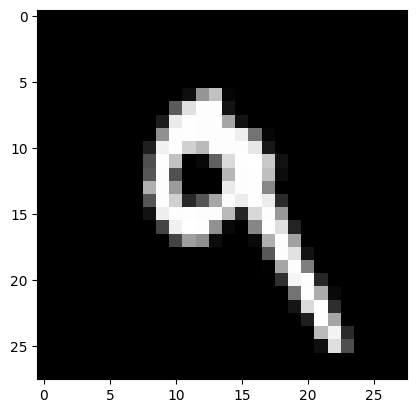

In [7]:
plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
enc.cpu().numpy().flatten()


1.c: Poglejmo si še, kako se slike gručijo oz. kam v latentni prostor se preslikajo. Dopolni vrstico, v kateri sliko zakodiraš v latentni prostor. 

In [8]:
encoded_samples = []
for sample in test_set:
    img = sample[0].unsqueeze(0)
    label = sample[1]
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)

Z uporabo metode TSNE lahko podatke (nelinearno) preslikamo v še nižjo dimenzijo in jih tako vizualiziramo. Kaj lahko opaziš na spodnjih slikah in ali si to pričakoval?

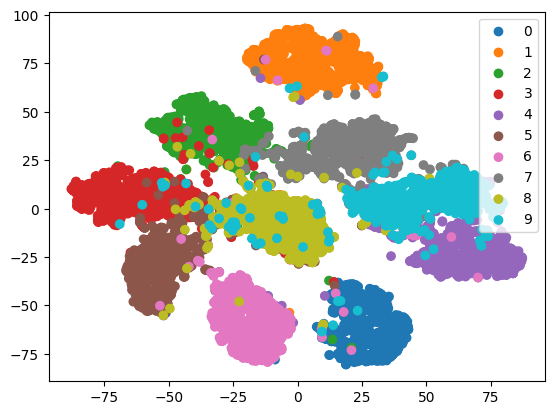

In [9]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
labels = encoded_samples["label"].to_numpy()

for i in range(10):
    indices = labels == i
    fig = plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], c=[plt.get_cmap("tab10").colors[i] for j in range(np.sum(indices))], label=i)

plt.legend()
plt.show()

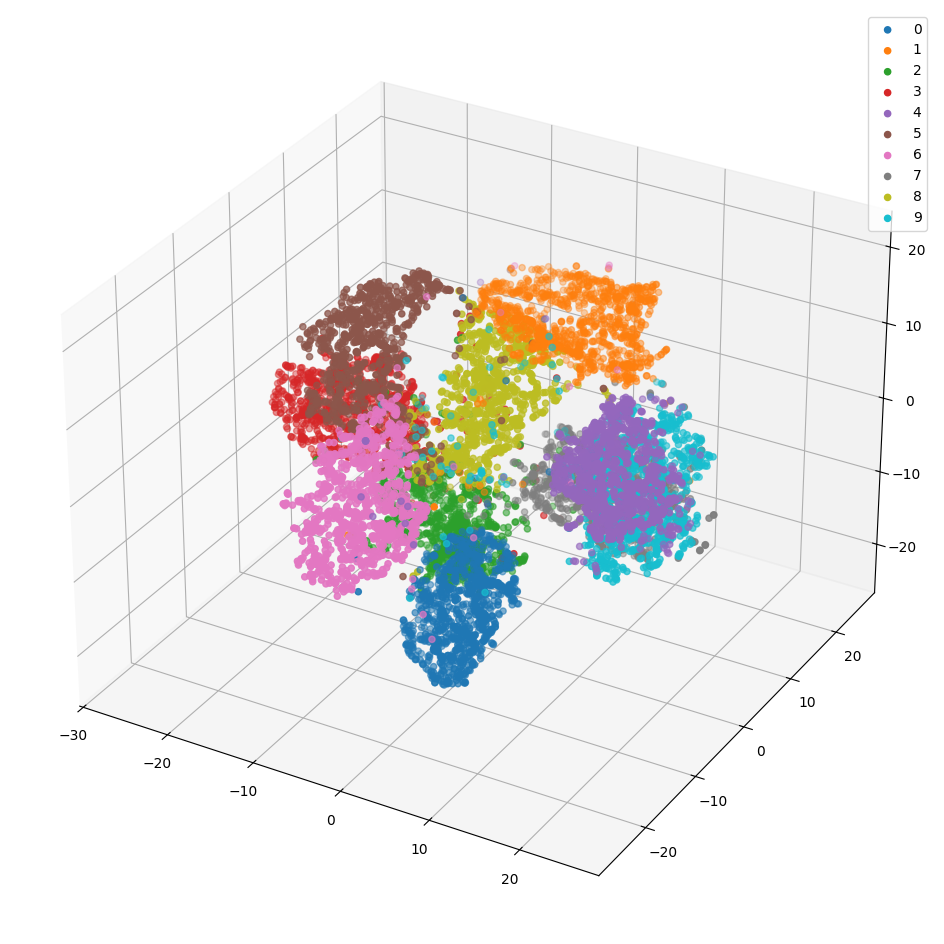

In [10]:
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
labels = encoded_samples["label"].to_numpy()

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

for i in range(10):
    indices = labels == i
    fig = ax.scatter(tsne_results[indices, 0], tsne_results[indices, 1], tsne_results[indices, 2], c=[plt.get_cmap("tab10").colors[i] for j in range(np.sum(indices))], label=i)

plt.legend()
plt.show()


1.d: Vidimo lahko torej, da so podatki z isto cilno vrednostjo, pogosto preslikani blizu v latentnem prostoru. S preslikanimi podatki si torej lahko pomagamo pri klasifikaciji. S spodnjo kodo podatke zakodiramo v latentni prostor in jih spremenimo v numpy array. Na podoben način pripravi testno množico in na njej preveri točnost napovednega modela SVM (SVC v sklearn-u) naučenega na učni množici

In [11]:
train_x = []
train_y = []

for sample in train_set:
    img = sample[0].unsqueeze(0)
    train_y.append(sample[1])
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    train_x.append(encoded_img.flatten().cpu().numpy())

train_x = np.array(train_x)
train_y = np.array(train_y)

In [12]:
test_x = []
test_y = []

for sample in test_set:
    img = sample[0].unsqueeze(0)
    test_y.append(sample[1])
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    test_x.append(encoded_img.flatten().cpu().numpy())

test_x = np.array(test_x)
test_y = np.array(test_y)

In [13]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_model = SVC(kernel='rbf')
svm_model.fit(train_x, train_y)

predictions = svm_model.predict(test_x)

accuracy = accuracy_score(test_y, predictions)
print(f"Točnost SVM modela: {accuracy:.4f}")

Točnost SVM modela: 0.9505


## Naloga 2: Rekurenčne nevronske mreže (GRU) 

2.a: Dopolni funkcijo `create_sequences`, ki sprejme časovno vrsto dolžine N ter parameter M (seq_length) in zgenerira N-M zaporedij dolžine M (torej prvo od indeksa 0 do indeksa M, drugo od 1 do M+1, itd.). Seznam sequences naj na koncu vsebuje 2-terice zaporedje, ciljna vrednost (naslednja vrednost v zaporedju).

In [14]:
from torch.utils.data import TensorDataset

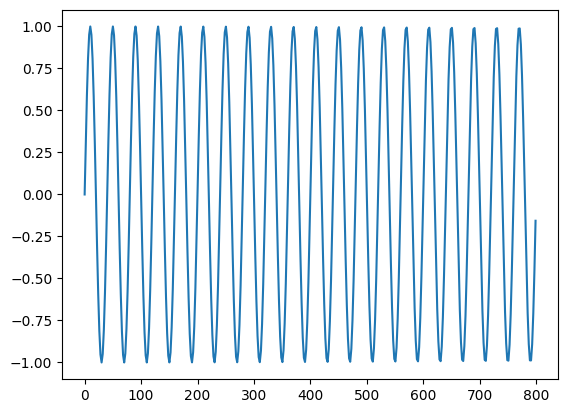

In [49]:
x = torch.linspace(0,799,400)
y = torch.sin(x*2*np.pi/40) 

test_size = 100
train_data = y[:-test_size]
test_data = y[-test_size:]

def create_sequences(data, seq_length):
    sequences = []
    N = len(data)
    for i in range(N-seq_length):
        seq = data[i:i + seq_length].unsqueeze(1) # [seq_len, 1] 2D oblika
        target = data[i + seq_length]
        sequences.append((seq, target))
    return sequences

seq_length = 20
train_sequences = create_sequences(train_data, seq_length)

plt.plot(x,y)

2.a: Dopolni spodnjo kodo, ki definira [GRU celico](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html). Vektor (matrika) h naj bo poljubne velikosti, izhodni vektor pa naj bo dobljen tako, da h pošlješ čez polno-povezan sloj ustreznih dimenzij. Sloje, ki jih boš potreboval/a lahko najdeš z uporabo nn.ImeSloja.

In [58]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        # GRU celica
        self.gru_cell = nn.GRUCell(input_size=input_size, hidden_size=hidden_size)
        #polno povezan sloj
        self.lin = nn.Linear(in_features=hidden_size, out_features=output_size)


    def forward(self, X):
        output = []
        h = torch.zeros(self.hidden_size)
        for t in range(X.shape[0]):
            h = self.gru_cell(X[t], h) #posodobimo skrito stanje
            out = self.lin(h)
            output += [out]

        output = torch.stack(output)
        return output[-1]

In [ ]:

# rešitve
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        # Definiramo potrebne sloje, na par matrike W in vektorja b iz formul lahko gledamo kot na polno-povezan sloj
        self.rx = nn.Linear(input_size, hidden_size) # reset gate - koliko prejšnjega stanja h uporabimo
        self.rh = nn.Linear(hidden_size, hidden_size) 
        self.zx = nn.Linear(input_size, hidden_size) # update gate - koliko nove informacije shranimo
        self.zh = nn.Linear(hidden_size, hidden_size)
        self.nx = nn.Linear(input_size, hidden_size) # new gate - kandidat za novo stanje
        self.nh = nn.Linear(hidden_size, hidden_size)
        self.output_layer = nn.Linear(hidden_size, output_size)


    def forward(self, X):
        output = []
        h = torch.zeros(self.hidden_size)
        for t in range(X.shape[0]):
            x = X[t].view(-1)
            # Podatke pošljemo čez polno-povezane sloje in jih obdelamo po formulah za GRU
            r = torch.sigmoid(self.rx(x) + self.rh(h))
            z = torch.sigmoid(self.zx(x) + self.zh(h))
            n = torch.tanh(self.nx(x) + r * self.nh(h))
            h = (1 - z) * n + z * h
            output += [self.output_layer(h)]

        output = torch.stack(output)
        return output[-1]


Model natreniraj in potestiraj na testnih podatkih

In [51]:
model = GRU(1, 10, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

epochs = 10
for epoch in range(epochs):
    print("Epoch ", epoch)
    total_loss = 0
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
    print(f"Loss {total_loss/len(train_sequences)}")



Epoch  0


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss 0.7651843316841743
Epoch  1
Loss 0.7634153863280517
Epoch  2
Loss 0.7616438894297711
Epoch  3
Loss 0.759875765551117
Epoch  4
Loss 0.7581123258647104
Epoch  5
Loss 0.7563538498094106
Epoch  6
Loss 0.7546005428540671
Epoch  7
Loss 0.7528525062238519
Epoch  8
Loss 0.7511096758757503
Epoch  9
Loss 0.7493720906056296


Točnost modela za napovedovanje numeričnih spremenljivk lahko ocenimo tudi z ($r^2$)[https://en.wikipedia.org/wiki/Coefficient_of_determination] metriko, ki nam pove koliko variance lahko z našim modelom napovemo.

In [18]:
from sklearn.metrics import r2_score

-0.20983576774597168


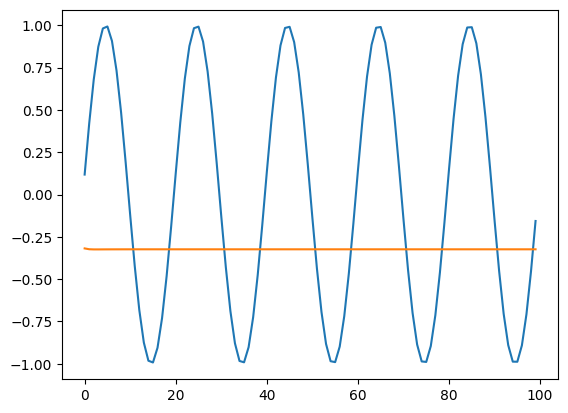

In [52]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(1)
    with torch.no_grad():
        res = model(seq)
        test_inputs.append(res.item())

print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()

2.c: Poišči vrednosti parametrov "learning_rate" in "hidden_size" pri katerih bo model dobro deloval.

In [55]:
hidden_sizes = [16, 32, 64]
learning_rates = [0.01, 0.005, 0.001, 0.0001]

best_score = -float('inf')
best_params = None

for hs in hidden_sizes:
    for lr in learning_rates:
        model = GRU(input_size=1, hidden_size=hs, output_size=1)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        epochs = 10
        for epoch in range(epochs):
            for i, (seq, labels) in enumerate(train_sequences):
                optimizer.zero_grad()
                y_pred = model(seq)
                loss = criterion(y_pred, labels)
                loss.backward()
                optimizer.step()
                total_loss += loss.detach().item()


        test_inputs = train_data[-seq_length:].tolist()
        model.eval()
        for i in range(test_size):
            seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(1)
            with torch.no_grad():
                res = model(seq)
                test_inputs.append(res.item())

        score = r2_score(test_data.numpy(), test_inputs[seq_length:])
        print(f"hidden_size={hs}, lr={lr}, R2={score:.4f}")

        if score > best_score:
            best_score = score
            best_params = (hs, lr)

print(f"\nNajboljši: hidden_size={best_params[0]}, learning_rate={best_params[1]}, R2={best_score:.4f}")

hidden_size=16, lr=0.01, R2=-0.3022


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=16, lr=0.005, R2=-0.5085


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=16, lr=0.001, R2=0.9982


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=16, lr=0.0001, R2=0.9598


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=32, lr=0.01, R2=0.0888


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=32, lr=0.005, R2=0.3410


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=32, lr=0.001, R2=0.2085


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=32, lr=0.0001, R2=0.9614


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=64, lr=0.01, R2=0.6203


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=64, lr=0.005, R2=-0.0834


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=64, lr=0.001, R2=0.9051


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


hidden_size=64, lr=0.0001, R2=0.9984

Najboljši: hidden_size=64, learning_rate=0.0001, R2=0.9984


In [59]:
model = GRU(1, best_params[0], 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=best_params[1])

epochs = 10
for epoch in range(epochs):
    print("Epoch ", epoch)
    total_loss = 0
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
    print(f"Loss {total_loss/len(train_sequences)}")

Epoch  0


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss 0.429084193829736
Epoch  1
Loss 0.3010072715228278
Epoch  2
Loss 0.07795294334653267
Epoch  3
Loss 0.0001356938859727343
Epoch  4
Loss 2.0508022843613544e-05
Epoch  5
Loss 1.6275686636300714e-05
Epoch  6
Loss 1.5935367509662638e-05
Epoch  7
Loss 1.5563337287468774e-05
Epoch  8
Loss 1.5120771425574427e-05
Epoch  9
Loss 1.4609120153068794e-05


0.999970555305481


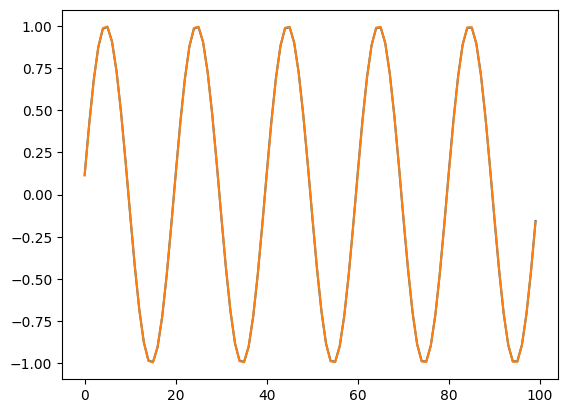

In [60]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(1)
    with torch.no_grad():
        res = model(seq)
        test_inputs.append(res.item())

print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()

2.d: Na podoben način sestavi novo podatkovno množico za časovno vrsto, ki je definirana s funkcijo $0.5\cdot\sin (2\cdot x\cdot\pi /40)+ \sin (2\cdot x\cdot\pi /400)$. Najdi model, ki bo tudi na teh podatkih dobro deloval. Pomagaš si lahko tako, da združiš več GRU celic ali pa sestaviš "močnejšo" LSTM celico.

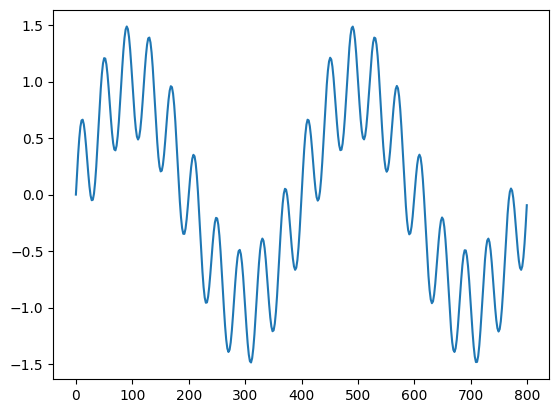

In [41]:
# priprava podatkov
x = torch.linspace(0,799,400)
y = 0.5 * torch.sin(2* x * np.pi /40) + torch.sin(2 * x * np.pi/400)

test_size = 100
train_data = y[:-test_size]
test_data = y[-test_size:]


seq_length = 20
train_sequences = create_sequences(train_data, seq_length)

plt.plot(x,y)

Long Short Term Memory networks – usually just called “LSTMs” – are a special kind of RNN, capable of learning long-term dependencies. They were introduced by Hochreiter & Schmidhuber (1997), and were refined and popularized by many people in following work. They work tremendously well on a large variety of problems, and are now widely used.

LSTMs are explicitly designed to avoid the long-term dependency problem. Remembering information for long periods of time is practically their default behavior, not something they struggle to learn!

LSTMs also have this chain like structure, but the repeating module has a different structure. Instead of having a single neural network layer, there are four, interacting in a very special way.

In [42]:
# definicija modela
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        self.lin = nn.Linear(in_features=hidden_size, out_features=output_size)



    def forward(self, X):
        output = []
        h = torch.zeros(self.hidden_size) #hidden state
        c = torch.zeros(self.hidden_size) #cell state
        for t in range(X.shape[0]): 
            h, c = self.lstm(X[t], (h, c)) #izvede en časovni korak LSTM celice — torej, obdeluje en vnos iz časovnega zaporedja in posodobi notranje stanje.
            out = self.lin(h)
            output += [out]
        
        output =torch.stack(output)
        return output[-1]

In [43]:

model = LSTM(1, 10, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.000001)

epochs = 10
for epoch in range(epochs):
    print("Epoch ", epoch)
    total_loss = 0
    for i, (seq, labels) in enumerate(train_sequences):
        optimizer.zero_grad()
        y_pred = model(seq)
        loss = criterion(y_pred, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.detach().item()
    print(f"Loss {total_loss/len(train_sequences)}")


Epoch  0


c:\Users\Uporabnik\anaconda3\envs\ITIAP\Lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Loss 0.7006764766091172
Epoch  1
Loss 0.6998220581922137
Epoch  2
Loss 0.6989468233617767
Epoch  3
Loss 0.6980706441880622
Epoch  4
Loss 0.6971958905342035
Epoch  5
Loss 0.6963233889233119
Epoch  6
Loss 0.695453456827454
Epoch  7
Loss 0.6945862147253657
Epoch  8
Loss 0.6937216165855067
Epoch  9
Loss 0.6928596859924645


-1.7129464149475098


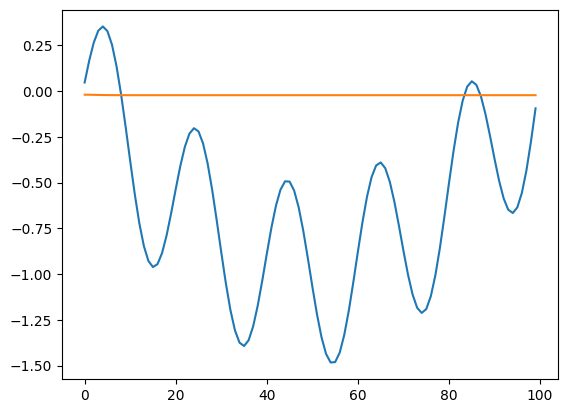

In [44]:
test_inputs = train_data[-seq_length:].tolist()
model = model.eval()
for i in range(test_size):
    seq = torch.FloatTensor(test_inputs[-seq_length:]).unsqueeze(1)
    with torch.no_grad():
        res = model(seq)
        test_inputs.append(res.item())

print(r2_score(test_data.numpy(), test_inputs[seq_length:]))

actual_predictions = test_inputs[seq_length:]
plt.plot(y.data.numpy()[-test_size:])
plt.plot(actual_predictions)
plt.show()